In [1]:
import numpy as np
from scipy import sparse
from scipy import linalg as la
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

import rom_operator_inference as roi

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["text.usetex"] = True

# ROM Operator Inference Example: One-dimensional Heat Equation

This example is based on the operator inference problem for the 1D heat equation described in the following paper, with some small changes in notation.

> Peherstorfer, B. and Willcox, K.
[Data-driven operator inference for non-intrusive projection-based model reduction.](https://www.sciencedirect.com/science/article/pii/S0045782516301104)
Computer Methods in Applied Mechanics and Engineering, 306:196-215, 2016.
([Download](https://cims.nyu.edu/~pehersto/preprints/Non-intrusive-model-reduction-Peherstorfer-Willcox.pdf))<details><summary>BibTeX</summary><pre>
@article{Peherstorfer16DataDriven,
    title     = {Data-driven operator inference for nonintrusive projection-based model reduction},
    author    = {Peherstorfer, B. and Willcox, K.},
    journal   = {Computer Methods in Applied Mechanics and Engineering},
    volume    = {306},
    pages     = {196--215},
    year      = {2016},
    publisher = {Elsevier}
}</pre></details>

## Problem Statement (non-parametric)

Let $\Omega = [0,L]\subset \mathbb{R}$ be the spatial domain indicated by the variable $\omega$, and let $[0,T]\subset\mathbb{R}$ be the time domain with variable $t$.
We consider the one-dimensional heat equation with nonhomogeneous Dirichlet boundary conditions,
$$
\begin{align}
    \frac{\partial}{\partial t} x(\omega,t) - \frac{\partial^2}{\partial\omega^2}x(\omega,t) &= 0
    & \omega &\in\Omega,\quad t\in[0,T],
    \\
    x(0,t) = x(L,t) &= 1
    & t &\in[0,T],
    \\
    x(\omega,0) &= 0
    & \omega &\in \Omega.
\end{align}
$$

Let $\{\omega_i\}_{i=0}^{n+1}$ be an equidistant grid of $n+2$ points on $\Omega$, i.e.,
$$
\begin{align*}
    0 &= \omega_0 < \omega_1 < \cdots < \omega_n < \omega_{n+1} = L
    &
    &\text{and}
    &
    \delta\omega &= \frac{L}{n+1} = \omega_{i+1} - \omega_{i},\quad i=1,\ldots,n-1.
\end{align*}
$$
Since the boundary conditions prescribe $x(\omega_0,t) = x(\omega_{n+1},t) = 1$, we wish to compute the state vector $\mathbf{x} = \begin{bmatrix} x(\omega_1,t) & \cdots & x(\omega_n,t)\end{bmatrix}^\mathsf{T}\in\mathbb{R}^n$ for various $t\in[0,T]$.

Introducing the finite difference approximation
$$
\begin{align*}
    \frac{\partial^2}{\partial\omega^2}x(\omega,t) &\approx \frac{x(\omega-\delta\omega,t) - 2x(\omega,t) + x(\omega+\delta\omega,t)}{(\delta\omega)^2}
    % &
    % \Longrightarrow&
    % &
    % \frac{\partial^2}{\partial\omega^2}x(\omega_i,t) &\approx \frac{x(\omega_{i-1},t) - 2x(\omega_{i},t) + x(\omega_{i+1},t)}{(\delta\omega)^2}
    % \\
    &
    &\Longrightarrow
    &
    \frac{\partial^2}{\partial\omega^2}x_{i} &\approx \frac{x_{i-1} - 2x_{i} + x_{i+1}}{(\delta\omega)^2},
\end{align*}
$$
we obtain the semi-discrete linear system
$$
\frac{d}{dt}\mathbf{x}(t) = A\mathbf{x} + B,
$$
where
$$
\begin{align}
    A &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{ccccc}
    -2 & 1 & & & \\
    1 & -2 & 1 & & \\
    & \ddots & \ddots & \ddots & \\
    & & 1 & -2 & 1 \\
    & & & 1 & -2 \\
    \end{array}\right] \in\mathbb{R}^{n\times n},
    &
    B &= \frac{1}{(\delta\omega)^2}\left[\begin{array}{c}
    1 \\ 0 \\ \cdots \\ 0 \\ 1
    \end{array}\right]\in\mathbb{R}^{n\times 1}.
\end{align}
$$

### Snapshot Data Generation

For simplicity, let $L = T = 1$.
We begin by simulating the full-order system described above with a maximal time step size $\delta t = 10^{-3}$, resulting in $k = 10^3+1$ time steps (1000 steps past the initial condition).
The result is the snapshot matrix $X\in\mathbb{R}^{n\times k}$, where the $j$th column is the solution trajectory at time $t_j$.
We also compute the derivative at each snapshot, obtaining $\dot{X}\in\mathbb{R}^{n\times k}$.

In [3]:
# Construct the spatial domain.
L = 1                           # Spatial domain length.
n = 127                         # Spatial grid size.
w_all = np.linspace(0, L, n+2)  # Full spatial grid.
w = w_all[1:-1]                 # Interior spatial grid (where x is unknown).
dw = w[1] - w[0]                # Spatial resolution.
dw2inv = 1 / dw**2

# Construct the temporal domain.
T = 1                           # Temporal domain length (final simulation time).
k = T*1000+1                    # Temporal grid size.
t = np.linspace(0, T, k)        # Temporal grid.
dt = t[1] - t[0]                # Temporal resolution.

print(f"Spatial step size dw = {dw}")
print(f"Temporal step size dt = {dt}")

Spatial step size dw = 0.0078125
Temporal step size dt = 0.001


In [4]:
# Construct state matrix A.
diags = np.array([1, -2, 1]) * dw2inv
A = sparse.diags(diags, [-1,0,1], (n,n))

# Construct input matrix B.
B = np.zeros_like(w)
B[0], B[-1] = dw2inv, dw2inv

# Define the full-order model dx/dt = f(t,x),  x(0) = x0.
f = lambda t,x: A @ x + B
x0 = np.zeros_like(w)

print(f"shape of A:\t{A.shape}")
print(f"shape of B:\t{B.shape}")
print(f"shape of x0:\t{x0.shape}")

shape of A:	(127, 127)
shape of B:	(127,)
shape of x0:	(127,)


In [5]:
# Compute snapshots by solving the equation with SciPy.
X = solve_ivp(f, [0,T], x0, t_eval=t, method="BDF").y

# Also compute velocities (dx/dt) at each snapshot.
Xdot = A @ X  + B.reshape((-1,1))

print(f"shape of X:\t{X.shape}")
print(f"shape of Xdot:\t{Xdot.shape}")

shape of X:	(127, 1001)
shape of Xdot:	(127, 1001)


Finally, we visualize the snapshots to get a sense of how the solution looks qualitatively.

In [6]:
def plot_heat_data(Z, title="Snapshot Data"):
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,4))

    # Plot a few snapshots.
    color = iter(plt.cm.viridis(np.linspace(.25, 1, 5)))
    for j in [0, 20, 80, 160, 640]:
        u = 0 if j == 0 else 1
        x_all = np.concatenate([[u], Z[:,j], [u]])
        ax1.plot(w_all, x_all, color=next(color), label=rf"$x(\omega,t_{{{j}}})$")
    ax1.set_xlim(0, 1)
    ax1.set_xlabel(r"Space $\omega$")
    ax1.set_ylabel(r"$x(\omega,t)$")
    ax1.legend(loc="lower right", fontsize=8, bbox_to_anchor=(1.01,.05))

    # Plot all snapshots in space and time.
    ww, tt = np.meshgrid(w, t)
    cdata = ax2.pcolormesh(ww, tt, Z.T, cmap="magma")
    plt.colorbar(cdata, ax=ax2, extend="both")
    ax2.set_xlabel(r"Space $\omega$")
    ax2.set_ylabel(r"Time $t$")

    fig.suptitle(title)
    plt.show()

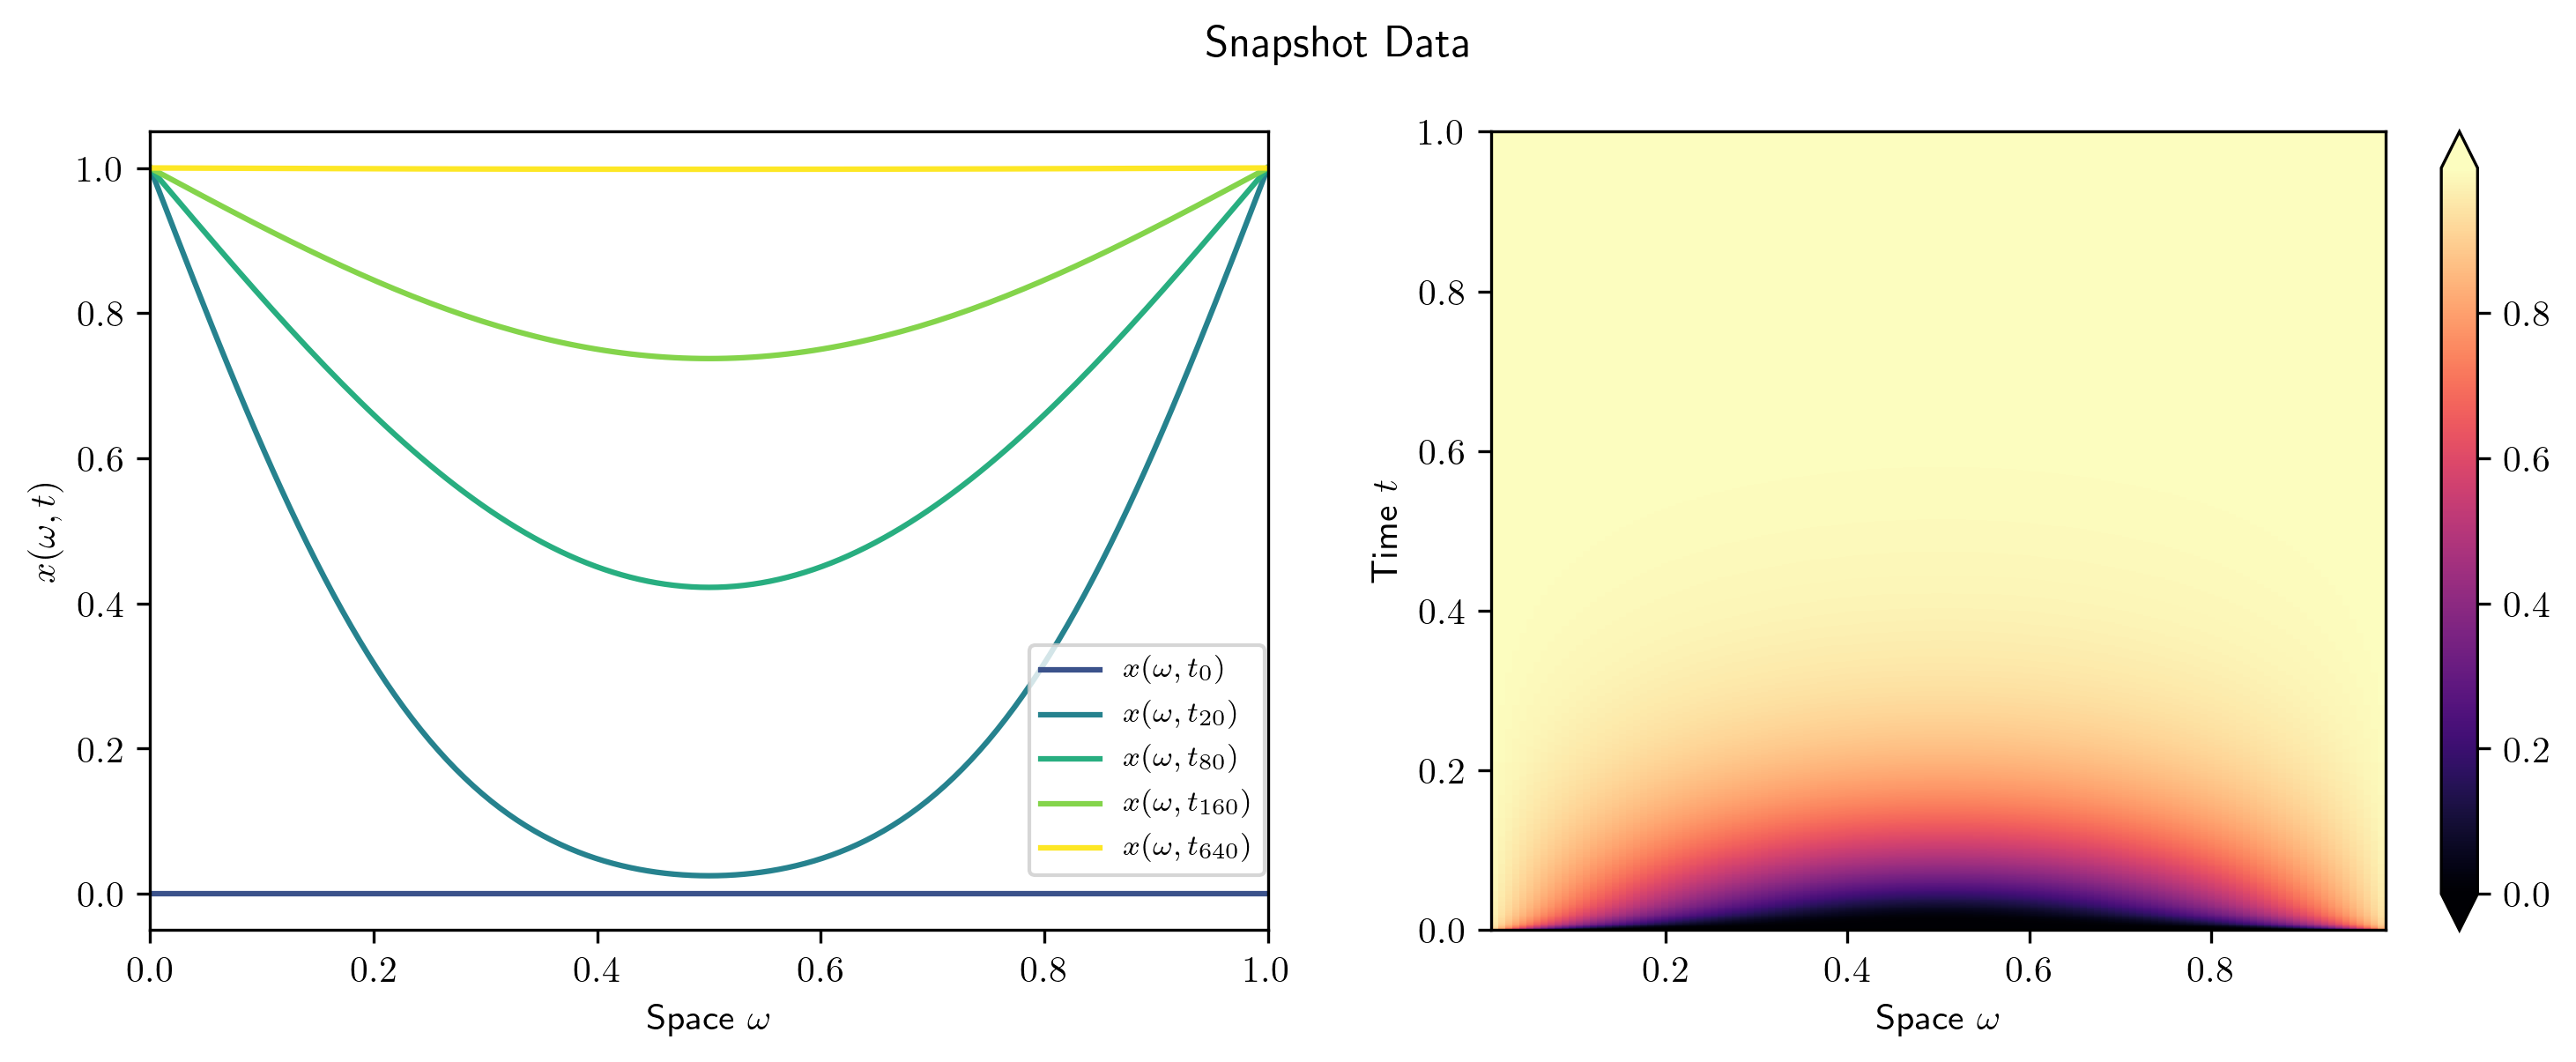

In [7]:
plot_heat_data(X)

### Reduced Model Construction

Now that we have snapshot data $X$, we can construct a POD basis $V_r$ to use in the construction of the ROM.
There are a few ways to make an informed choice of $r$; in this example, we examine the _projection error_, defined by
$$
\text{err}_\text{projection} = \frac{||X - V_rV_r^\mathsf{T}X||_F}{||X||_F}.
$$
We choose $r$ so that the projection error is under $10^{-5}$.

7

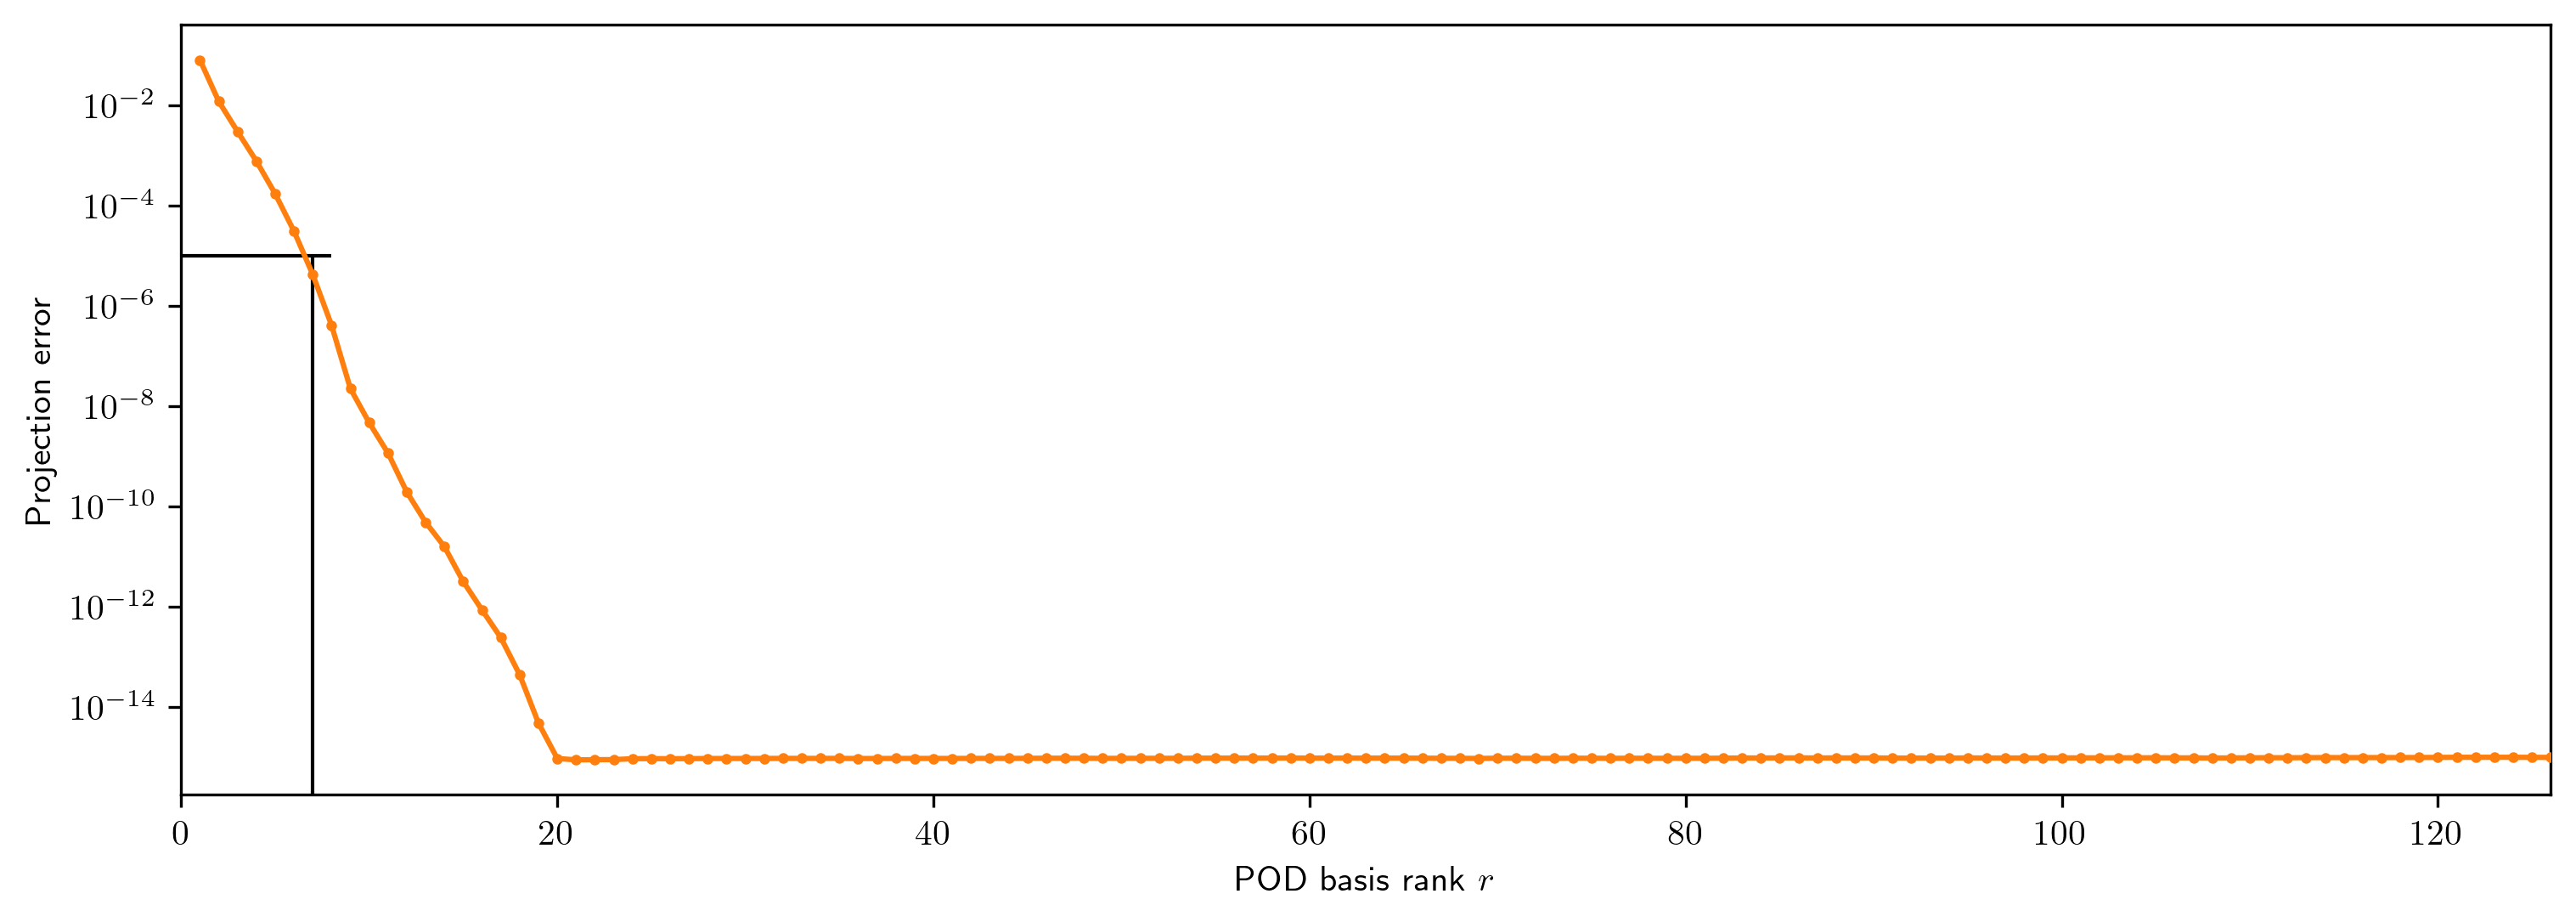

In [8]:
roi.pre.minimal_projection_error(X, eps=1e-5, plot=True)

In this case, $r = 7$ is enough to lower the projection error below $10^{-5}$.
To be safe, we select $r = 8$.

In [9]:
Vr = roi.pre.pod_basis(X, r=8)
roi.pre.projection_error(X, Vr)

4.100738837582127e-07

Now we can learn the reduced model with operator inference.
Because the full-order model is of the form $\dot{\mathbf{x}} = A\mathbf{x} + B,$ we could equivently specify a reduced model form of $\dot{\hat{\mathbf{x}}} = \hat{A}\hat{\mathbf{x}} + \hat{\mathbf{c}}$ (`modelform='Lc'`, `has_inputs=False`) or $\dot{\hat{\mathbf{x}}} = \hat{A}\hat{\mathbf{x}} + \hat{B}u(t)$ with constant inputs $u(t) = 1$ (`modelform='L'`, `has_inputs=True`).

In [10]:
# Linear model with constant ("no input").
model1 = roi.InferredContinuousModel(modelform="Lc", has_inputs=False)
model1.fit(X, Xdot, Vr)
X_ROM1 = model1.predict(x0, t, method="BDF")

# Linear model with input (but homogeneous).
model2 = roi.InferredContinuousModel(modelform="L", has_inputs=True)
model2.fit(X, Xdot, Vr, U=np.ones(X.shape[1]))
u = lambda t: 1
X_ROM2 = model2.predict(x0, t, u, method="BDF")

print(f"Normed difference betweeen methods: {la.norm(X_ROM1 - X_ROM2)}")

Normed difference betweeen methods: 0.0


This shows that the methods are equivalent.
For the error analysis, since we used the projection error to determine $r$, we use a similar measure to evaluate the state error:
$$
\text{err}_\text{state} = \frac{||X - X_\text{ROM}||_F}{||X||_F}.
$$

In [11]:
inferred_model = model1
X_ROM_inferred = X_ROM1
roi.post.frobenius_error(X, X_ROM_inferred)[1]

0.0001792888386175954

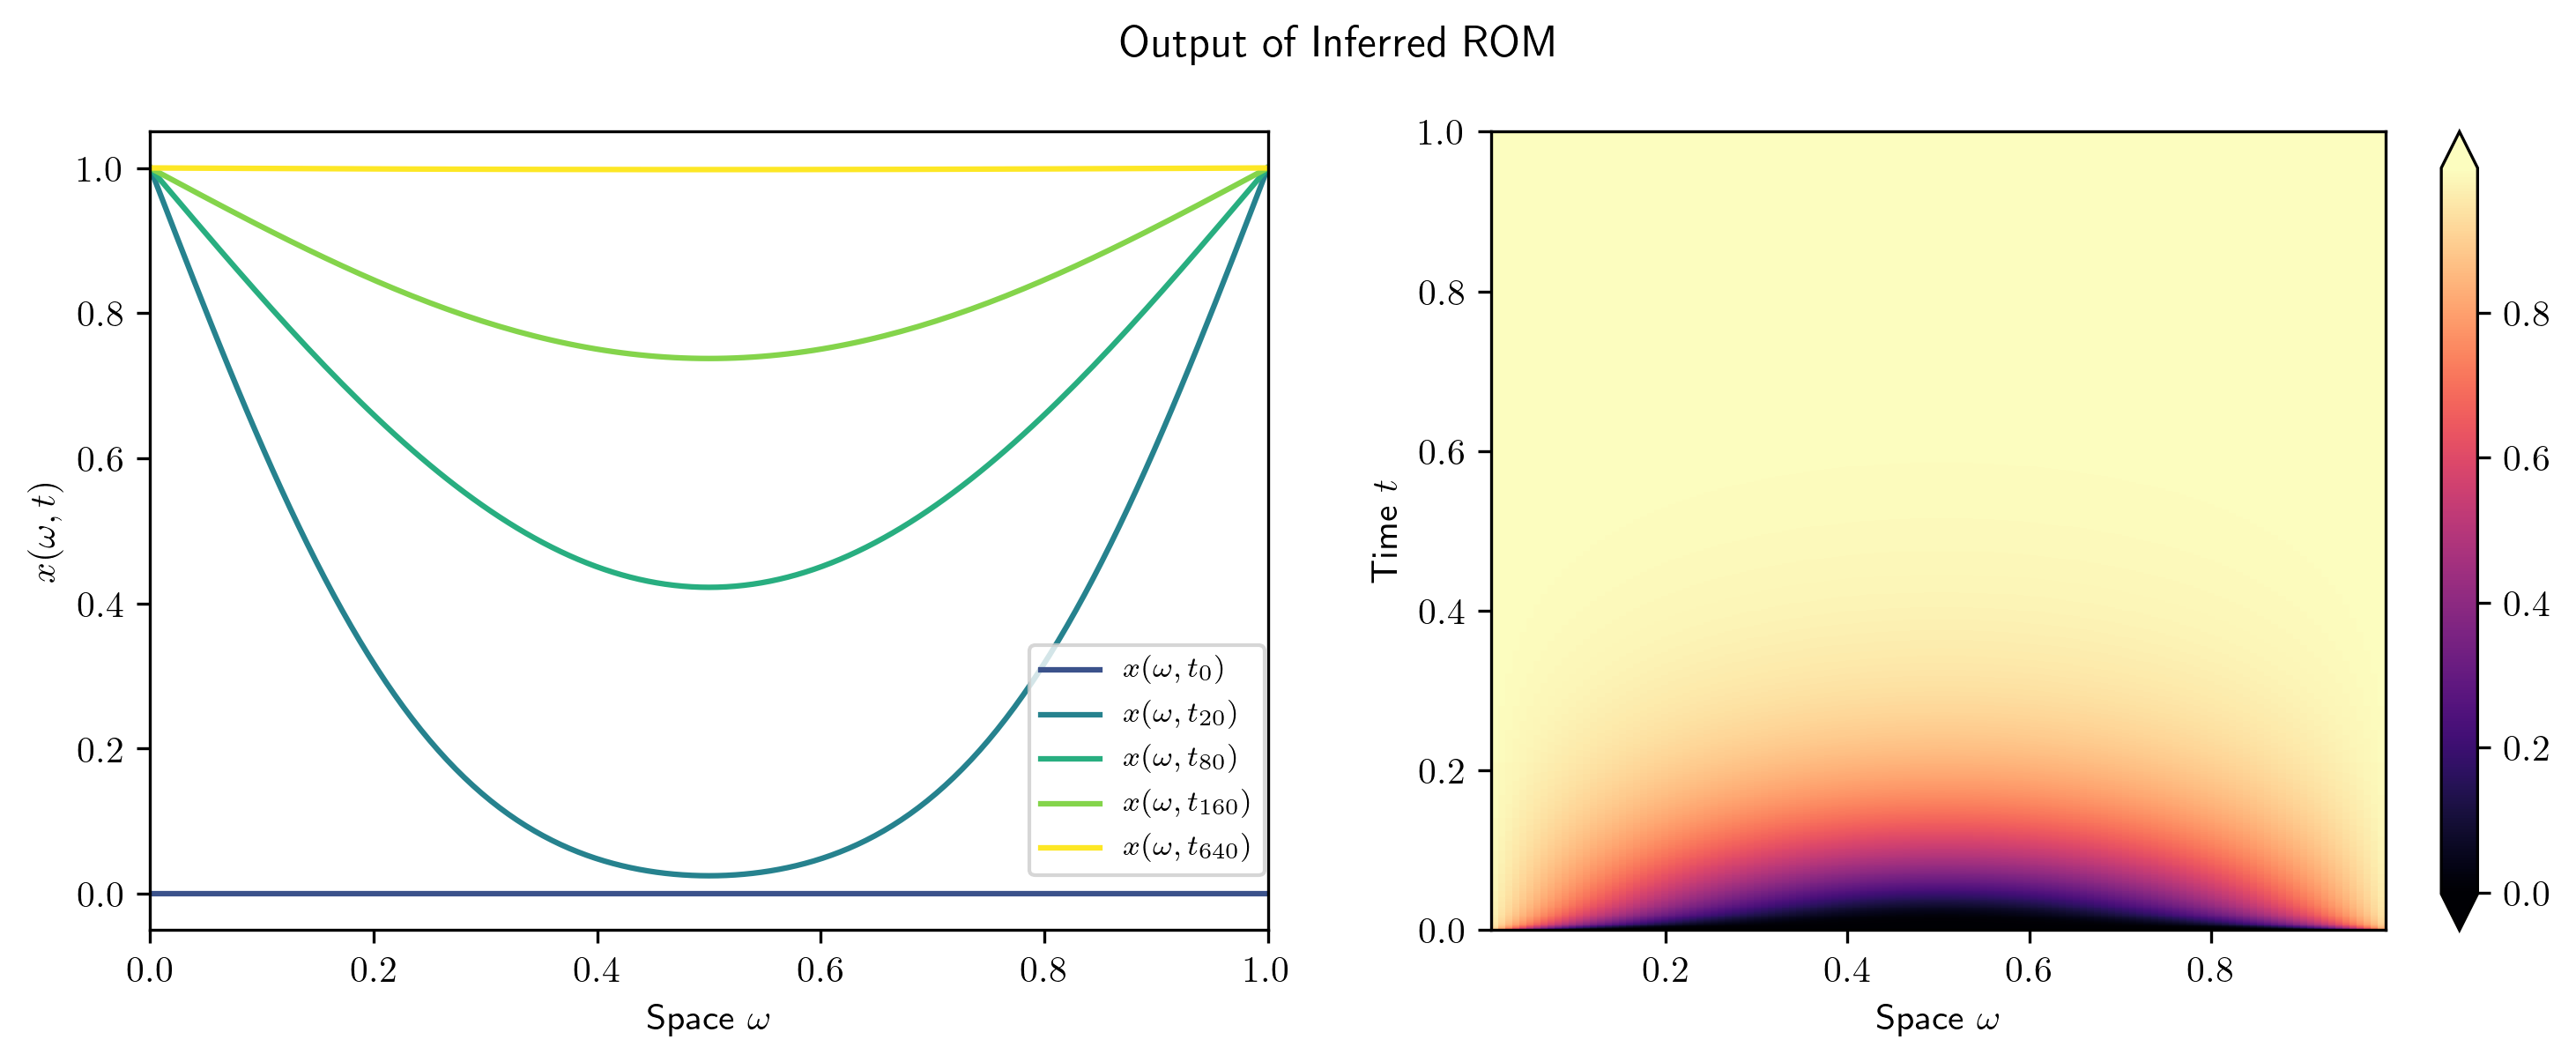

In [12]:
plot_heat_data(X_ROM_inferred, "Output of Inferred ROM")

We can also check how well we did relative to the projection error.

In [13]:
relative_projection_error = roi.post.lp_error(X, Vr @ Vr.T @ X, normalize=True)[1]

def plot_relative_errors_over_time(Zlist, labels):
    colors = ["C3", "C5"]
    for Z,label,c in zip(Zlist, labels, colors[:len(Zlist)]):
        relative_l2_error = roi.post.lp_error(X, Z, normalize=True)[1]
        plt.semilogy(t, relative_l2_error, c, label=label)
    plt.semilogy(t, relative_projection_error, "C1", label="Projection Error")

    plt.xlabel(r"Time $t$")
    plt.legend(loc="upper right")
    plt.title(r"Relative $\ell^2$ Error in Time")
    plt.show()

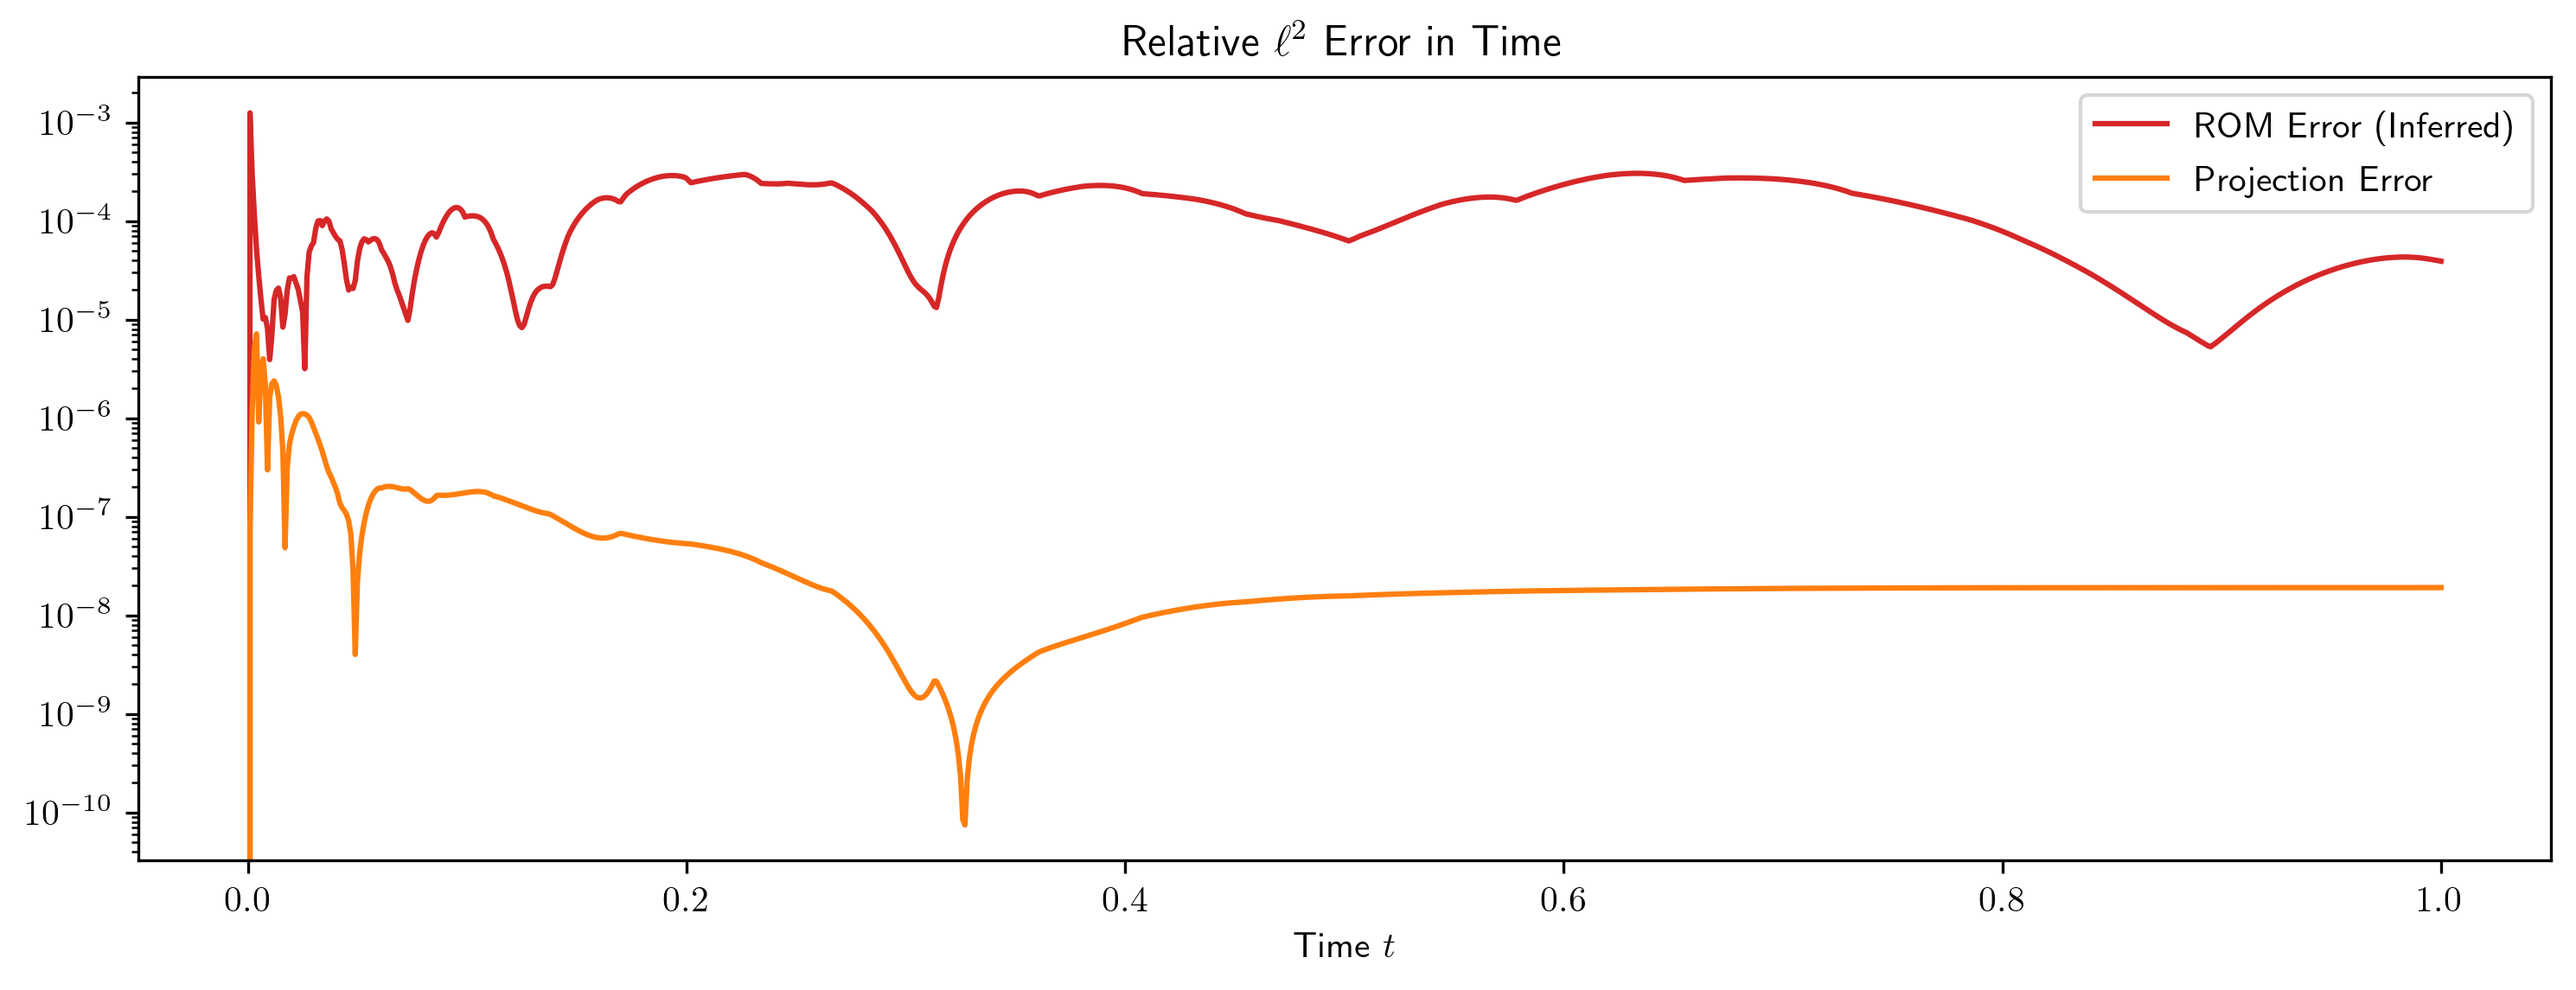

In [14]:
plot_relative_errors_over_time([X_ROM_inferred], ["ROM Error (Inferred)"])

### Comparison with Projection-based Methods

Under some idealized assumptions, the operators learned through operator inference "converge" in a sense to the corresponding projected operators
$$
\begin{align*}
    \tilde{A} &= V_{r}^\mathsf{T} A V_{r}^\mathsf{T},
    &
    \tilde{B} &= V_{r}^\mathsf{T}B.
\end{align*}
$$
We construct these reduced operators for comparison.

In [15]:
intrusive_model = roi.IntrusiveContinuousModel(modelform="Lc", has_inputs=False)
intrusive_model.fit([A, B], Vr)
X_ROM_intrusive = intrusive_model.predict(x0, t, method="BDF")

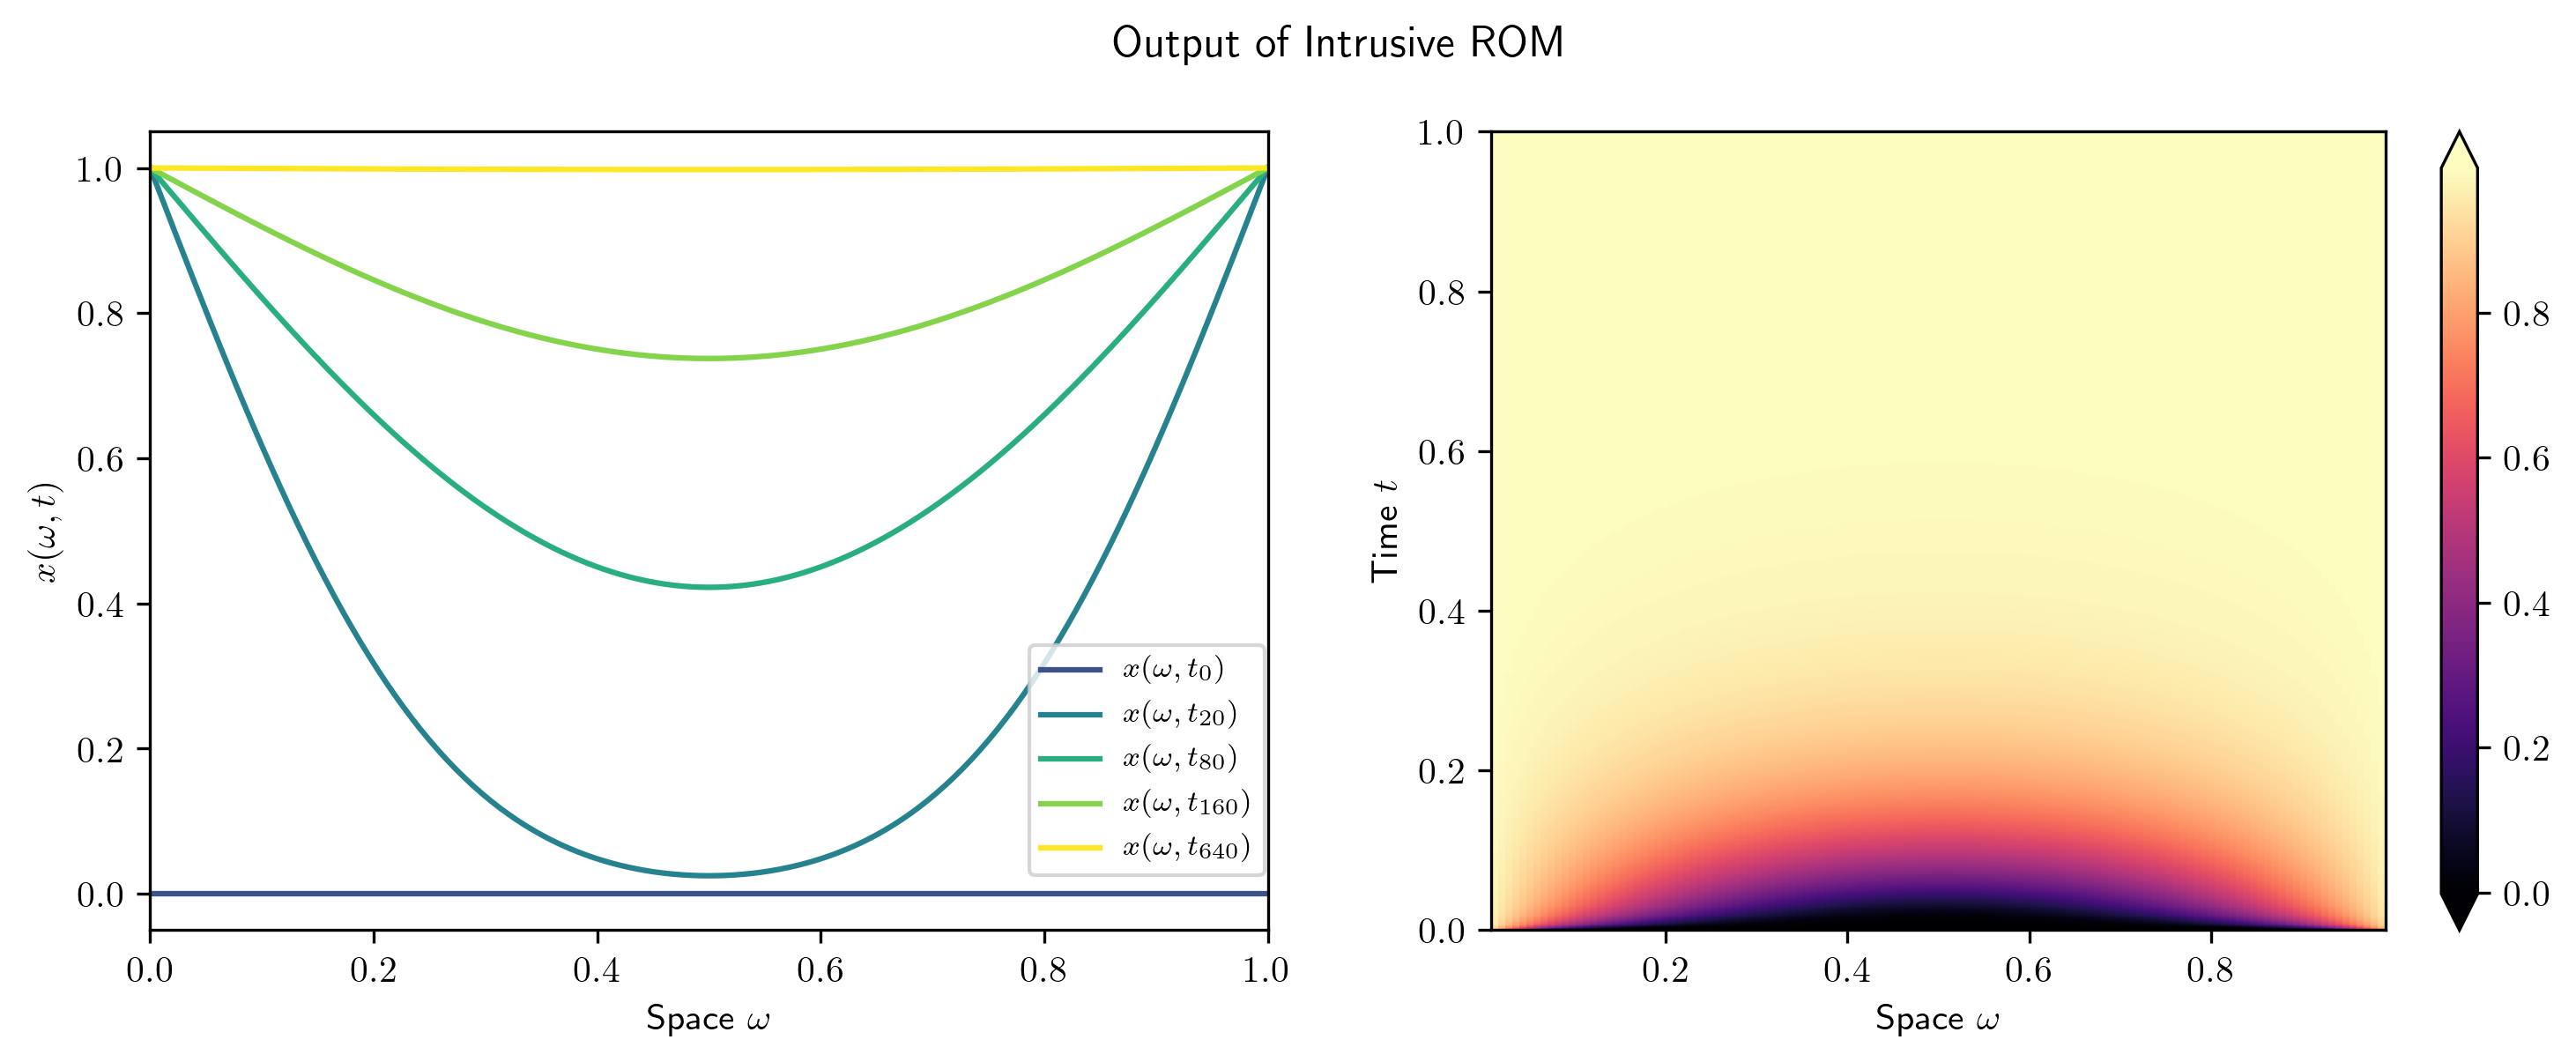

In [16]:
plot_heat_data(X_ROM_intrusive, "Output of Intrusive ROM")

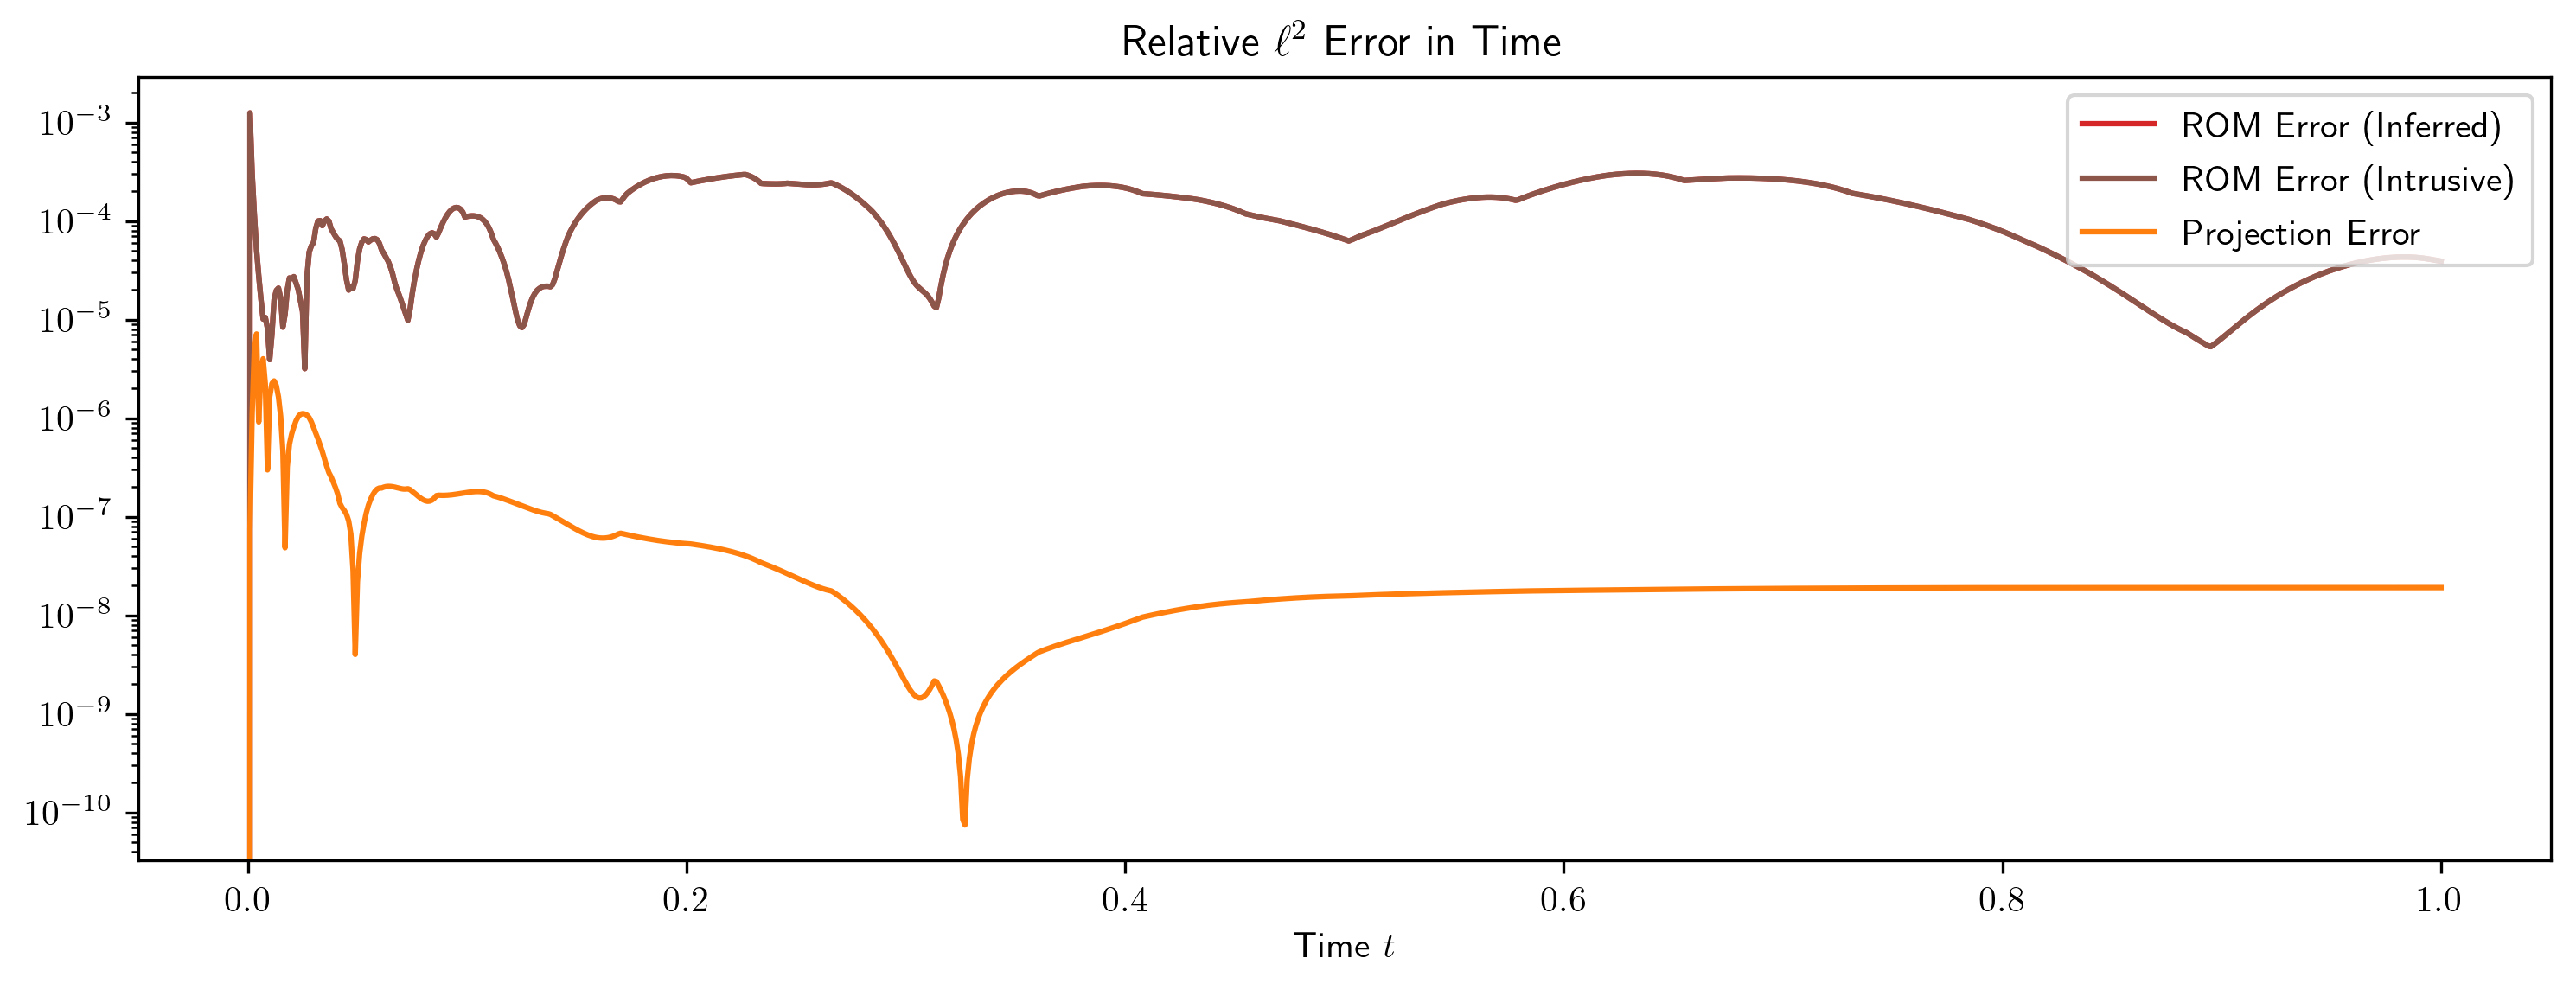

In [17]:
plot_relative_errors_over_time([X_ROM_inferred, X_ROM_intrusive],
                               ["ROM Error (Inferred)", "ROM Error (Intrusive)"])

In [18]:
la.norm(X_ROM_intrusive - X_ROM_inferred)

1.0803074060904576e-09

In this case, **the inferred and projected ROMs give essentially the same result**.
In fact, the resulting operators are very close:

In [19]:
la.norm(inferred_model.A_ - intrusive_model.A_)

1.2878310280425264e-05

In [20]:
la.norm(inferred_model.c_ - intrusive_model.c_)

1.6448969061002435e-05

The key contribution is that the inferred model successfuly (nearly) constructs the same ROM as an intrusive method, but it does so **without explicit knowledge of the operators $A$ and $B$**.

## The Parametric Setting

We now extend our problem to allow for different heat conductivities.
Consider the parameter domain $\mathcal{D} = [0.1,10]\subset\mathbb{R}$ with variable $\mu$.
We examine the parametrized heat equation

$$
\begin{align}
    \frac{\partial}{\partial t} x(\omega,t;\mu) - \mu\frac{\partial^2}{\partial\omega^2}x(\omega,t;\mu) &= 0
    & \omega &\in\Omega,\quad t\in[0,T],
    \\
    x(0,t;\mu) = x(1,t;\mu) &= 1
    & t &\in[0,T],
    \\
    x(\omega,0;\mu) &= 0
    & \omega &\in \Omega.
\end{align}
$$

Previously, we solved this problem for $\mu = 1$.
To construct a model for any $\mu\in\mathcal{D}$, we take equally distributed samples $\{\mu_i\}_{i=1}^{p}\subset\mathcal{D}$ and let $X(\mu_1$), ..., $X(\mu_{p})$ be the corresponding snapshots computed for each sampled parameter value.
We then contruct a (global) POD basis so that the average projection error,
$$
    \text{err}_\text{projection} = \frac{1}{p}\sum_{i=1}^{p}\frac{||X(\mu_i) - V_r V_r^\mathsf{T}X(\mu_i)||_F}{||X(\mu_i)||_F},
$$
is about $10^{-5}$.
We choose $p = 10$ in the experiment.

The numerical setup is almost identical to the previous problem, except that the semi-discrete linear system is scaled by $\mu$:
$$
   \frac{d}{dt}\mathbf{x}(t) = \mu\cdot\left(A\mathbf{x} + B\right).
$$

In [21]:
p = 10                          # Number of parameter samples.
r = 8                           # Dimension of reduced-order model.
# mus = np.linspace(.1, 10, p)    # Get p equidistant values of mu from D = [.1, 10].
mus = np.logspace(-1, 1, p)     # Get p logarithmically spaced values of mu from D = [.1, 10]. 

# Gather snapshot data for each parameter value by running the FOM for each mu.
Xs, Xdots = [], []
for mu in mus:
    f = lambda t,x: mu * (A @ x + B)
    Xmu = solve_ivp(f, [0,T], x0, t_eval=t, method="BDF").y
    Xdotmu = mu * (A @ Xmu  + B.reshape((-1,1)))
    Xs.append(Xmu)
    Xdots.append(Xdotmu)

# Compute the POD basis of rank r using snapshot data from all parameter samples.
Vr = roi.pre.pod_basis(np.hstack(Xs), r)
V_proj = Vr @ Vr.T

# Compute the resulting projection error.
total_relative_projection_error = 0
for X in Xs:
    total_relative_projection_error += roi.pre.projection_error(X, Vr)
average_relative_projection_error = total_relative_projection_error / p

print(average_relative_projection_error)

3.824584196456892e-05


Our strategy to account for the parameter $\mu$ is to learn a separate reduced model for each sampled $\mu_i$, $i=1,\ldots,p$.
Then, for a new parameter value $\tilde{\mu}\in\mathcal{D}$, we interpolate the entries of the learned reduced models to create a new reduced model corresponding to $\tilde{\mu}\in\mathcal{D}$.
The `InterpolatedInferredContinuousModel` class encapsulates this process.

In [22]:
# Learn reduced models for each parameter value.
pmodel = roi.InterpolatedInferredContinuousModel(modelform="Lc", has_inputs=False)
pmodel.fit(mus, Xs, Xdots, Vr)

We begin by evaluating the interpolated model at the parameter samples (i.e. the training data) and computing the average Frobenius error,

$$
\frac{1}{p}\sum_{i=1}^p\frac{||X(\mu_i) - X_\text{ROM}(\mu_i)||_F}{||X(\mu_i)||_F}.
$$

In [23]:
total_error = 0
for i,mu in enumerate(mus):
    X_ROM_mui = pmodel.predict(mu, x0, t, method="BDF")
    total_error += roi.post.frobenius_error(Xs[i], X_ROM_mui)[1]
average_error = total_error / p
average_error

0.0007434890542211994

Now we compare the inferred ROM with the corresonding intrusive ROMs, varying the reduced dimension $r$.
We run experiments for the training parameters $\{\mu_i\}_{i=1}^p$ and for $5$ other parameters $\mu\in\mathcal{D}$.

In [24]:
def error_at_mu(vals, r):
    # Construct the inferred model.
    # Construct the intrusive model.
    
    # Simulate the FOM and each ROM at each mu value, tracking errors.
    error_inference = 0
    error_intrusive = 0
    for v in vals:
        # FOM
        f = lambda t,x: v * (A @ x + B)
        Xmu = solve_ivp(f, [0,T], x0, t_eval=t, method="BDF").y
        Vrtemp = roi.pre.pod_basis(Xmu, r)
        
        # Inferred ROM
        inferred_pmodel = roi.InterpolatedInferredContinuousModel("Lc", False)
        inferred_pmodel.fit(mus, Xs, Xdots, Vr[:,:r])
        X_ROM_inferred = inferred_pmodel.predict(v, x0, t, method="BDF")
        
        # Intrusive ROM
        intrusive_pmodel = roi.IntrusiveContinuousModel("Lc", False)
        intrusive_pmodel.fit([v*A, v*B], Vr[:,:r])
        X_ROM_intrusive = intrusive_pmodel.predict(x0, t, method="BDF")
        
        error_inference += roi.post.frobenius_error(Xmu, X_ROM_inferred)[1]
        error_intrusive += roi.post.frobenius_error(Xmu, X_ROM_intrusive)[1]
    
    trials = len(vals)
    return error_inference / trials, error_intrusive / trials 

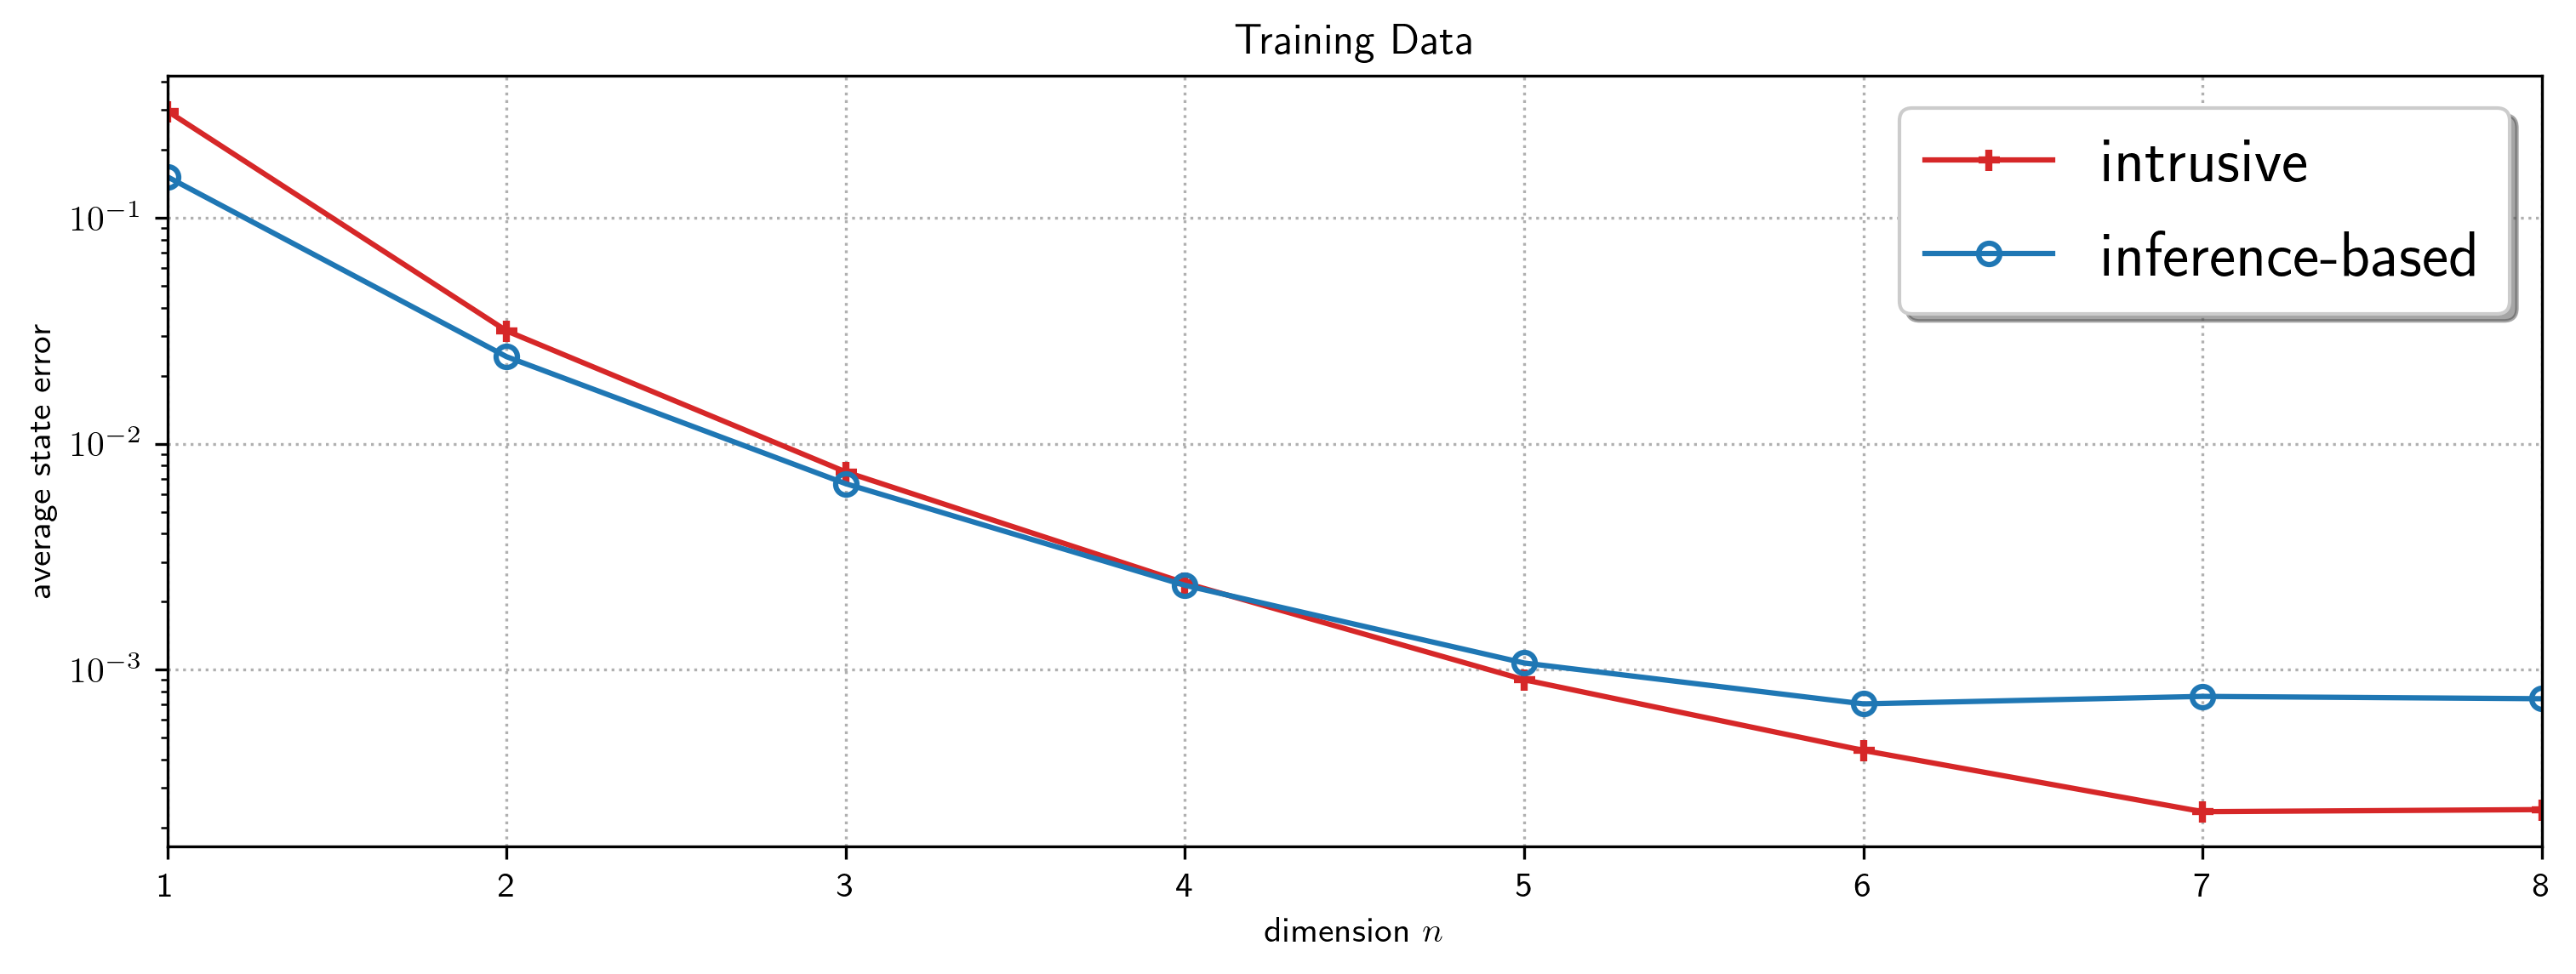

In [25]:
rs = np.arange(1, 9)

inference_errors = []
intrusive_errors = []
for r in rs:
    e_inf, e_int = error_at_mu(mus, r)
    inference_errors.append(e_inf)
    intrusive_errors.append(e_int)

plt.semilogy(rs, intrusive_errors, 'C3+-', label="intrusive", mew=2)
plt.semilogy(rs, inference_errors, 'C0o-', label="inference-based", mfc='none', mec='C0', mew=1.5)

plt.xlim(rs.min(), rs.max())
plt.xticks(rs, [str(int(r)) for r in rs])
plt.xlabel(r"dimension $n$")
plt.ylabel(r"average state error")
plt.legend(loc="upper right", fontsize=18, shadow=True, framealpha=1)
plt.grid(ls=':')
plt.title("Training Data")
plt.show()

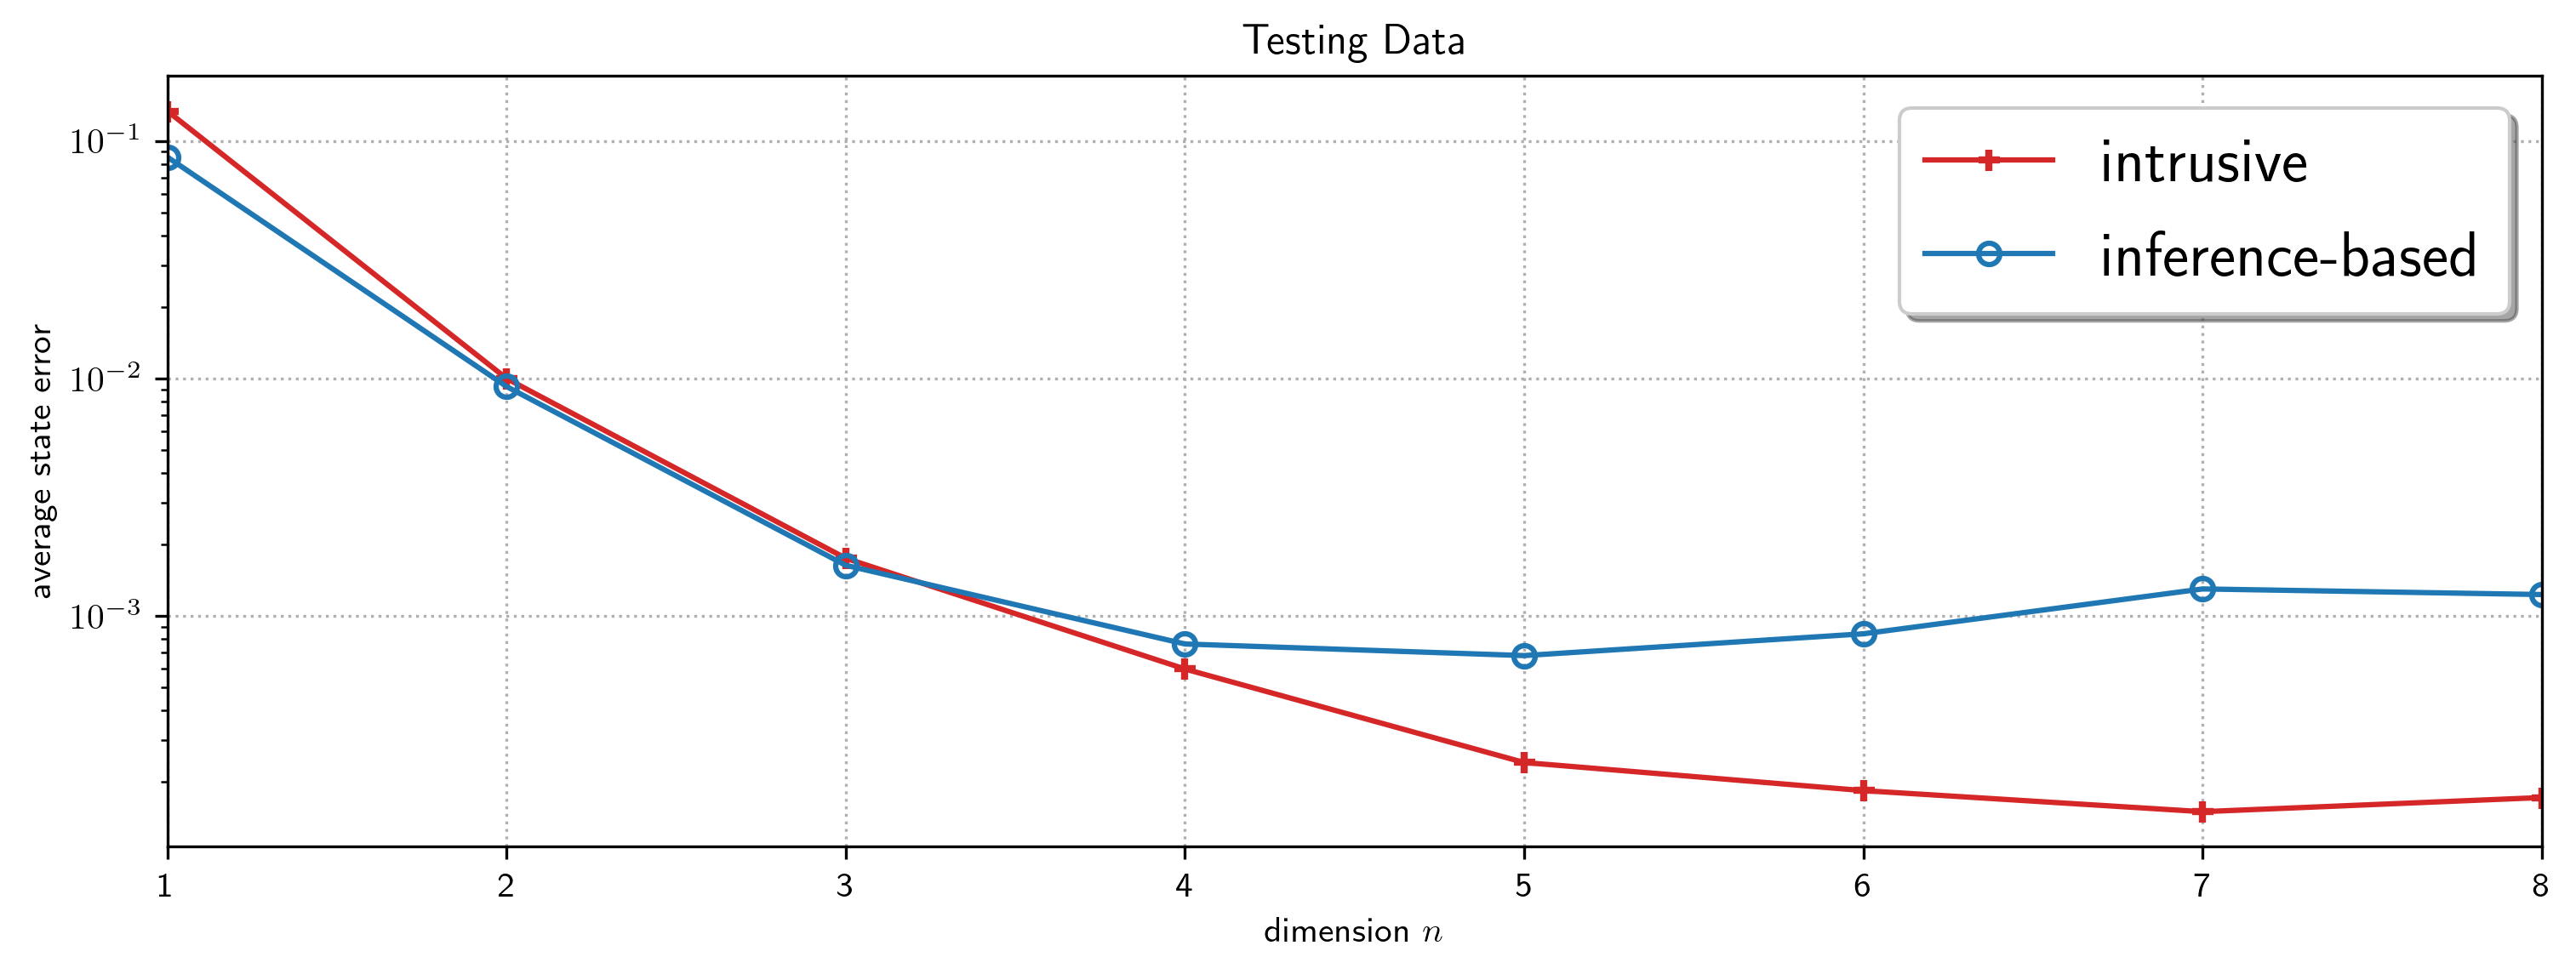

In [26]:
rs = np.arange(1, 9)

inference_errors = []
intrusive_errors = []
vals = np.random.uniform(.1, 10, 5)
for r in rs:
    e_inf, e_int = error_at_mu(vals, r)
    inference_errors.append(e_inf)
    intrusive_errors.append(e_int)

plt.semilogy(rs, intrusive_errors, 'C3+-', label="intrusive", mew=2)
plt.semilogy(rs, inference_errors, 'C0o-', label="inference-based", mfc='none', mec='C0', mew=1.5)

plt.xlim(rs.min(), rs.max())
plt.xticks(rs, [str(int(r)) for r in rs])
plt.xlabel(r"dimension $n$")
plt.ylabel(r"average state error")
plt.legend(loc="upper right", fontsize=18, shadow=True, framealpha=1)
plt.grid(ls=':')
plt.title("Testing Data")
plt.show()

```python
# Run each of the models and get the average error.
state_errs = []
for s in range(1,r+1):
    state_error = 0
    for m,X in zip(models, Xs):
        # Construct a model of order s by pulling out submatrices.
        if s < r:
            mnew = roi.InferredContinuousModel("Lc", False)
            mnew.r = s
            mnew.Vr = m.Vr[:,:s]
            mnew.A_ = m.A_[:s,:s]
            mnew.c_ = m.c_[:s]
            mnew.F_ = None
            mnew.B_ = None
            mnew.m = 1
            mnew.n = 127
            mnew._construct_f_()
            X_ROM = mnew.predict(x0, t, method="BDF")
        else:
            X_ROM = m.predict(x0, t, method="BDF")
        state_error += (la.norm(X - X_ROM) / la.norm(X))**2
    state_error /= p
    state_errs.append(state_error)
```